In [1]:
import pandas as pd
import numpy as np
import matplotlib
import sys

from readCanLitefileUtils import *
from calibUtils import *

In [2]:
# define the inputs

#file 1 (DACset 0x000)
#file_DACset000 = './files/21-05-06_160653_calib_SN04_DACSet000_20x.csv'
#file_DACset000 = './files/SN11/21-05-20_110216_DACset000_SN11_20x.csv'
#file_DACset000 = './files/SN11/21-05-20_110216_DACset000_SN11_20x_v2.csv'
#file_DACset000 = './files/SN11/21-05-28_105657_DACset000_SN11_20x_v3.csv'
#file_DACset000 = './files/SN15/21-05-27_151342_DACset000_SN15_20x.csv'
#file_DACset000 = './files/SN10/21-06-03_111911_precalib_SN10_DACset000_v0_100x.csv'
#file_DACset000 = './files/SN06/21-06-03_100832_precalib_SN06_dacset000_v0_100x.csv'
#file_DACset000 = './files/SN06/21-06-04_143330_precalib_SN06_dacset000_v1_100x.csv'
#file_DACset000 = './files/SN03/21-06-07_172024_SN03_DACset000_100x_v0.csv'
#file_DACset000 = './files/SN05/21-06-10_145854_procalib_DACset000_SN05_100x_v0.csv'
#file_DACset000 = './files/SN09/21-06-10_174657_procalib_DACset000_SN09_100x_v0.csv'
file_DACset000 = './files/SN12/21-06-30_114226_procalib_SN12_DACset000_v0_100x.csv'
#file_DACset000 = './files/SN13/21-06-29_173726_procalib_SN13_DACset000_v0_100x.csv'
#file_DACset000 = './files/SN22/21-07-02_141809_procalib_SN22_DACset000_v0_100x.csv'
#file_DACset000 = './files/SN14/21-07-02_152341_procalib_SN14_DACset000_v0_100x.csv'


#file 2 (DACset 0xFFF)
#file_DACsetFFF = './files/21-05-06_160653_calib_SN04_DACSetFFF_20x.csv'
#file_DACsetFFF = './files/SN11/21-05-20_110216_DACsetFFF_SN11_20x.csv'
#file_DACsetFFF = './files/SN11/21-05-20_110216_DACsetFFF_SN11_20x_v2.csv'
#file_DACsetFFF = './files/SN11/21-05-28_105657_DACsetFFF_SN11_20x_v3.csv'
#file_DACsetFFF = './files/SN10/21-06-03_111911_precalib_SN10_DACsetFFF_v0_100x.csv'
#file_DACsetFFF = './files/SN06/21-06-03_100832_precalib_SN06_dacsetFFF_v0_100x.csv'
#file_DACsetFFF = './files/SN06/21-06-04_143330_precalib_SN06_dacsetFFF_v1_100x.csv'
#file_DACsetFFF = './files/SN03/21-06-07_172024_SN03_DACsetFFF_100x_v0.csv'
#file_DACsetFFF = './files/SN05/21-06-10_170534_procalib_DACsetFFF_SN05_100x_v0.csv'
#file_DACsetFFF = './files/SN09/21-06-10_174657_procalib_DACsetFFF_SN09_100x_v0.csv'
file_DACsetFFF = './files/SN12/21-06-30_114226_procalib_SN12_DACsetFFF_v0_100x.csv'
#file_DACsetFFF = './files/SN13/21-06-29_173726_procalib_SN13_DACsetFFF_v0_100x.csv'
#file_DACsetFFF = './files/SN22/21-07-02_141809_procalib_SN22_DACsetFFF_v0_100x.csv'
#file_DACsetFFF = './files/SN14/21-07-02_152341_procalib_SN14_DACsetFFF_v0_100x.csv'



#SN11
#DMMmin = [108.718, 108.744, 108.752, 108.746, 108.739, 108.722, 
#          108.736, 108.699, 108.750, 108.747, 108.743, 108.732]

#DMMmax = [116.288, 116.275, 116.328, 116.291, 116.273, 116.282,
#          116.311, 116.267, 116.327, 116.316, 116.219, 116.250]

#SN11 v3
#DMMmin = [108.716, 108.745, 108.750, 108.745, 108.740, 108.722, 
#          108.736, 108.700, 108.750, 108.747, 108.744, 108.733]

#DMMmax = [116.287, 116.313, 116.326, 116.324, 116.314, 116.293,
#          116.312, 116.268, 116.329, 116.315, 116.220, 116.304]

#SN15
#DMMmin = [108.744, 108.715, 108.768, 108.729, 108.751, 108.717, 
#          108.708, 108.712, 108.760, 108.729, 108.759, 108.726]

#DMMmax = [116.318, 116.291, 116.347, 116.302, 116.329, 116.293,
#          116.279, 116.289, 116.335, 116.305, 116.333, 116.298]


#SN10
#DMMmin = [108.747, 108.771, 108.755, 108.772, 108.766, 108.762, 
#          108.787, 108.761, 108.779, 108.759, 108.752, 108.774]

#DMMmax = [116.324, 116.337, 116.329, 116.360, 116.347, 116.337,
#          116.365, 116.335, 116.354, 116.332, 116.333, 116.345]


#SN06
#DMMmin = [108.736, 108.736, 108.737, 108.734, 108.752, 108.754, 
#          108.747, 108.755, 108.746, 108.757, 108.760, 108.743]

#DMMmax = [116.310, 116.306, 116.317, 116.310, 116.325, 116.332,
#          116.324, 116.327, 116.323, 116.335, 116.345, 116.318]


#SN03
#DMMmin = [108.731, 108.708, 108.736, 108.735, 108.707, 108.718, 
#          108.711, 108.721, 108.742, 108.714, 108.705, 108.727]

#DMMmax = [116.300, 116.274, 116.310, 116.304, 116.282, 116.289,
#          116.282, 116.300, 116.316, 116.284, 116.277, 116.301]


#SN05
#DMMmin = [108.750, 108.715, 108.739, 108.776, 108.757, 108.763, 
#           108.741, 108.731, 108.755, 108.748, 108.743, 108.737]

#DMMmax = [116.323, 116.287, 116.312, 116.350, 116.328, 116.336,
#          116.322, 116.308, 116.333, 116.324, 116.326, 116.316]

#SN09
#DMMmin = [108.740, 108.741, 108.741, 108.754, 108.742, 108.747, 
#          108.748, 108.758, 108.723, 108.757, 108.762, 108.755]

#DMMmax = [116.309, 116.310, 116.311, 116.323, 116.311, 116.326,
#          116.321, 116.337, 116.295, 116.334, 116.340, 116.326]

#SN012
DMMmin = [108.725, 108.767, 108.758, 108.749, 108.751, 108.747, 
          108.711, 108.755, 108.787, 108.736, 108.742, 108.730]

DMMmax = [116.284, 116.340, 116.331, 116.316, 116.324, 116.319,
          116.274, 116.324, 116.366, 116.311, 116.316, 116.295]

#SN013
#DMMmin = [108.725, 108.731, 108.754, 108.731, 108.741, 108.723, 
#          108.741, 108.741, 108.759, 108.750, 108.777, 108.749]

#DMMmax = [116.290, 116.302, 116.325, 116.300, 116.314, 116.304,
#          116.306, 116.318, 116.330, 116.326, 116.355, 116.328]

#SN22
#DMMmin = [108.730, 108.743, 108.733, 108.733, 108.744, 108.746, 
#          108.744, 108.746, 108.728, 108.749, 108.748, 108.744]

#DMMmax = [116.306, 116.309, 116.313, 116.302, 116.314, 116.307,
#          116.319, 116.317, 116.296, 116.322, 116.325, 116.318]

#SN14
#DMMmin = [108.744, 108.732, 108.757, 108.761, 108.739, 108.722, 
#          108.740, 108.719, 108.753, 108.745, 108.734, 108.748]

#DMMmax = [116.320, 116.307, 116.332, 116.338, 116.318, 116.301,
#          116.307, 116.291, 116.329, 116.318, 116.312, 116.331]

#file_HVoff = './files/SN11/21-05-20_110216_HVoff_SN11_20x.csv'
#file_HVoff = './files/SN11/21-05-28_105657_HVoff_SN11_20x_v3.csv'
#file_HVoff = './files/SN15/21-05-27_151342_HVoff_SN15_20x.csv'
#file_HVoff = './files/SN10/21-06-03_111911_precalib_SN10_HVoff_v0_100x.csv'
#file_HVoff = './files/SN06/21-06-03_100832_precalib_SN06_HVoff_v0_100x.csv'
#file_HVoff = './files/SN03/21-06-07_172024_SN03_HVoff_100x_v0.csv'
#file_HVoff = './files/SN05/21-06-10_171045_HVoff_SN05_100x_v0.csv'
#file_HVoff = './files/SN09/21-06-10_174657_procalib_HVoff_SN09_100x_v0.csv'
file_HVoff = './files/SN12/21-06-30_114226_procalib_SN12_HVoff_v0_100x.csv'
#file_HVoff = './files/SN13/21-06-29_173726_procalib_SN13_HVoff_v0_100x.csv'
#file_HVoff = './files/SN22/21-07-02_141809_procalib_SN22_HVoff_v0_100x.csv'
#file_HVoff = './files/SN14/21-07-02_152341_procalib_SN14_HVoff_v0_100x.csv'



#SN11
#DMMHVmin = 1.305
#DMMHVmax = 120.

#DMMHVmin = 1.381
#DMMHVmax = 119.997


#SN15
#DMMHVmin = 1.387
#DMMHVmax = 119.992

#SN10
#DMMHVmin = 1.381
#DMMHVmax = 119.997

#SN06
#DMMHVmin = 1.384
#DMMHVmax = 119.996

#SN03
#DMMHVmin = 1.380
#DMMHVmax = 119.996

#SN05
#DMMHVmin = 1.378
#DMMHVmax = 119.994

#SN09
#DMMHVmin = 1.378
#DMMHVmax = 119.992

#SN012
DMMHVmin = 1.373
DMMHVmax = 120.00

#SN13
#DMMHVmin = 1.368
#DMMHVmax = 119.987

#SN22
#DMMHVmin = 1.379
#DMMHVmax = 119.998


#SN14
#DMMHVmin = 1.388
#DMMHVmax = 119.987


#data for HV calibration (SN04)
#data_HV = {'ADCmin': [0x02EB], 'DMMmin': [1.378], 'ADCmax': [0xFEB5], 'DMMmax': [120]}
#df_HV = pd.DataFrame(data=data_HV)

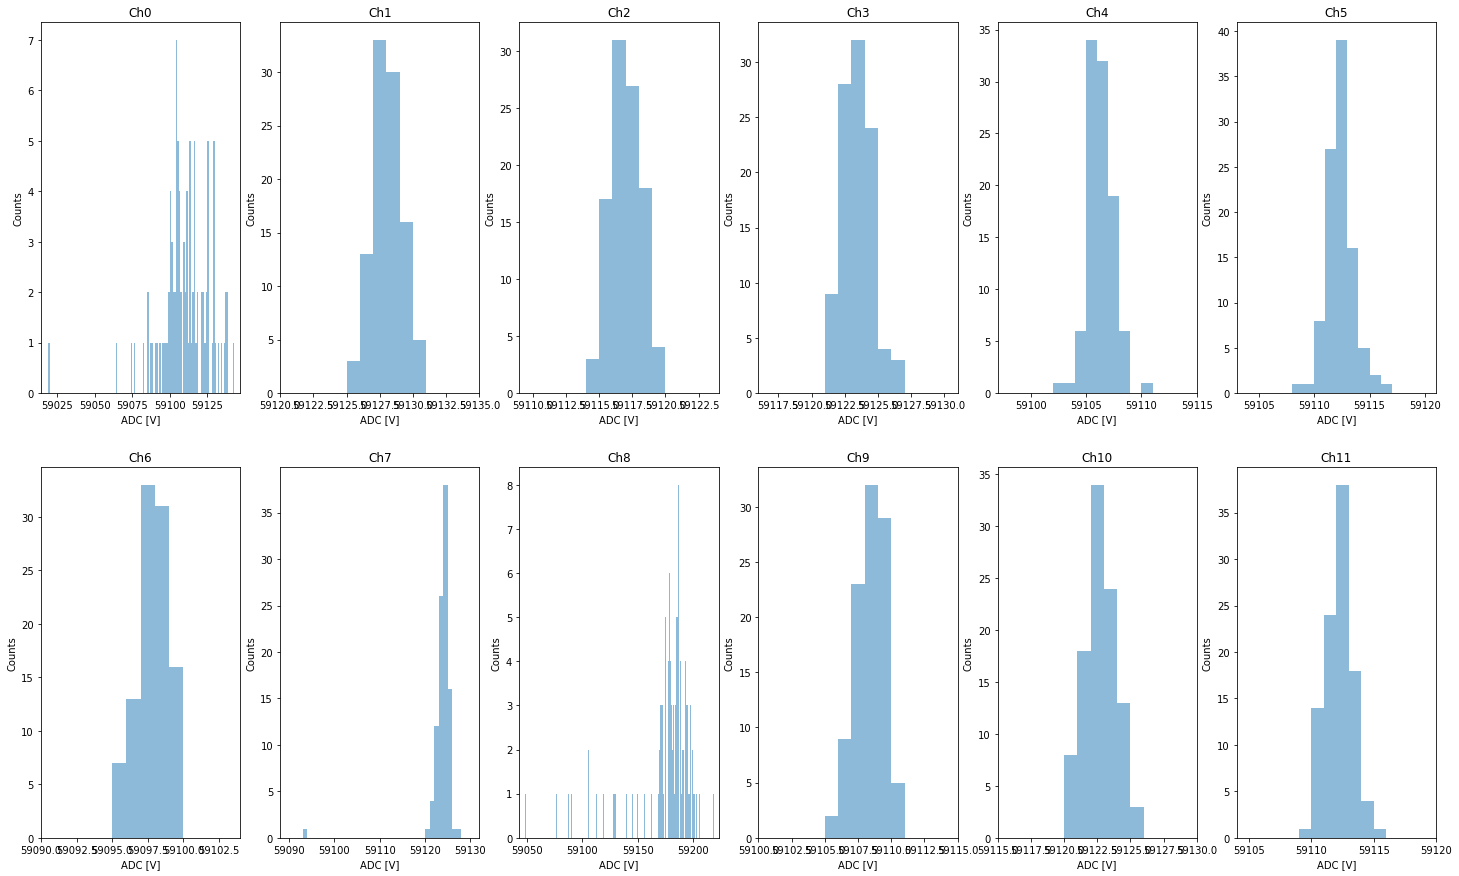

-----
0x0
['e6e5', 'e6f8', 'e6ed', 'e6f3', 'e6e2', 'e6e8', 'e6d9', 'e6f3', 'e726', 'e6e4', 'e6f2', 'e6e8']
0xfda6


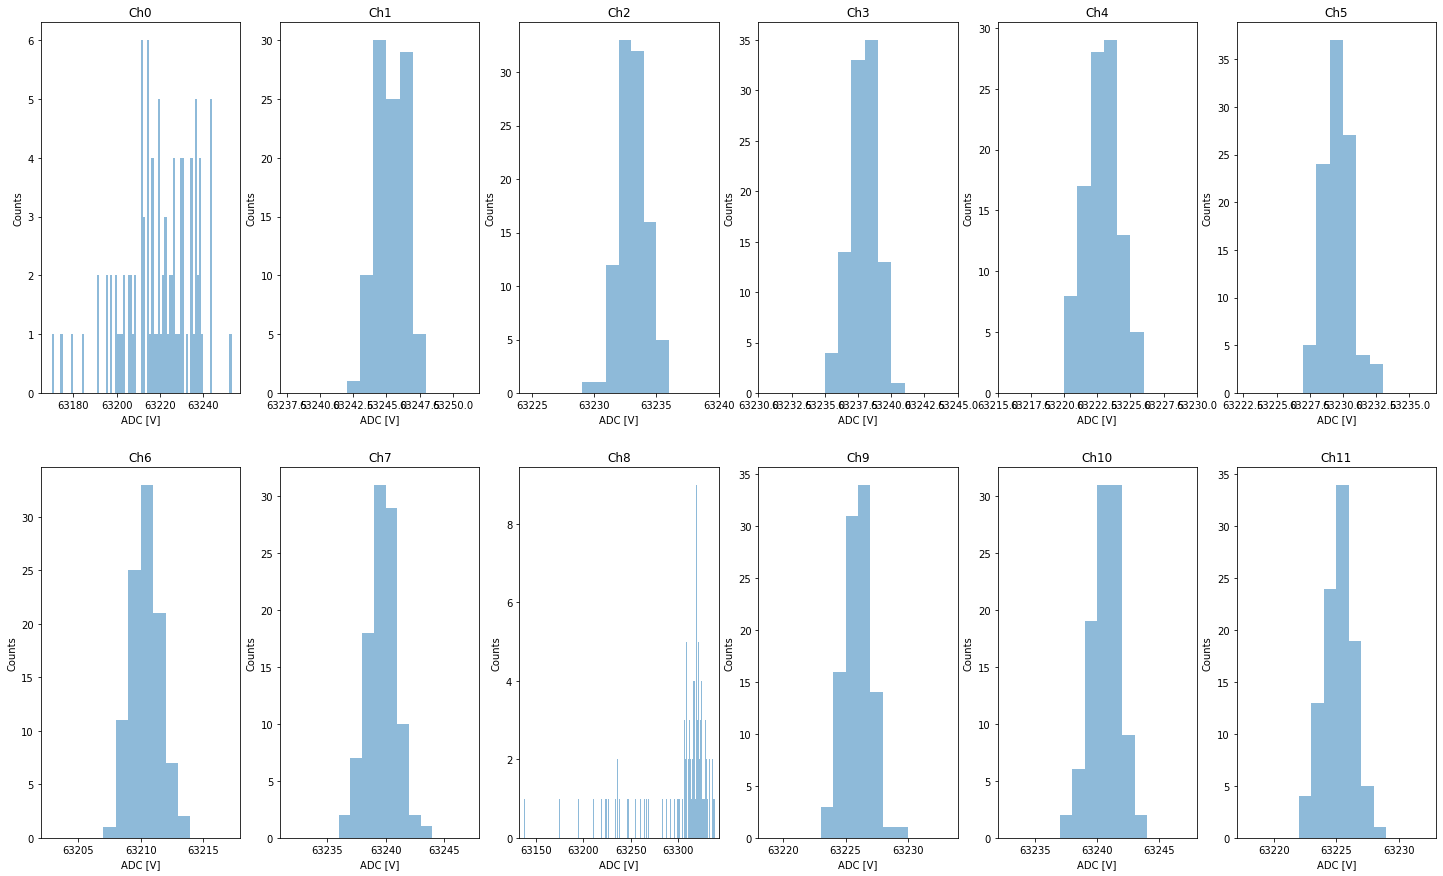

0xfff
['f6f3', 'f70d', 'f701', 'f705', 'f6f6', 'f6fd', 'f6ea', 'f707', 'f743', 'f6f9', 'f708', 'f6f9']
0xfd91


In [3]:
DACset000, ADCmin, HVmin = GetADCvalues(file_DACset000)
print('-----')
print(DACset000)
print(ADCmin)
print(HVmin)

DACsetFFF, ADCmax, HVmax = GetADCvalues(file_DACsetFFF)
print(DACsetFFF)
print(ADCmax)
print(HVmax)



In [4]:
#the HVmin value is overwitten by the good one which comes from the file with HV OFF

HVmin = GetHVvalue(file_HVoff)
HVmin

'0x803d'

In [5]:
#data for HV calibration
data_HV = {'ADCmin': [HVmin], 'DMMmin': [DMMHVmin], 'ADCmax': [HVmax], 'DMMmax': [DMMHVmax]}
df_HV = pd.DataFrame(data=data_HV)
df_HV

,ADCmin,DMMmin,ADCmax,DMMmax
0,0x803d,1.373,0xfd91,120.0


DACset000 = '0x0'
DACsetFFF = '0xfff'
#tmp fix for SN11

In [6]:
#build the dataframe to use to extract the calibration parameters
if (DACset000 == '0x0'):
    col0 = 'ADCmin'
else: 
    #print('Error! not the expected values for the DACset')
    sys.exit('Error! not the expected values for the DACset')


if (DACsetFFF == '0xfff'):
    col3 = 'ADCmax'
else: 
    sys.exit('Error! not the expected values for the DACset')
    

df_out = pd.DataFrame(list(zip(ADCmin, DMMmin, ADCmax, DMMmax)), columns = [col0, 'DMMmin' ,  col3, 'DMMmax'])
df_out

,ADCmin,DMMmin,ADCmax,DMMmax
0,e6e5,108.725,f6f3,116.284
1,e6f8,108.767,f70d,116.340
2,e6ed,108.758,f701,116.331
3,e6f3,108.749,f705,116.316
4,e6e2,108.751,f6f6,116.324
5,e6e8,108.747,f6fd,116.319
6,e6d9,108.711,f6ea,116.274
7,e6f3,108.755,f707,116.324
8,e726,108.787,f743,116.366
9,e6e4,108.736,f6f9,116.311


In [7]:
#convert ADCmin and ADCmax in decimal numbers
df_out = hex_to_dec(df_out)
df_out

,ADCmin,DMMmin,ADCmax,DMMmax
0,59109,108.725,63219,116.284
1,59128,108.767,63245,116.340
2,59117,108.758,63233,116.331
3,59123,108.749,63237,116.316
4,59106,108.751,63222,116.324
5,59112,108.747,63229,116.319
6,59097,108.711,63210,116.274
7,59123,108.755,63239,116.324
8,59174,108.787,63299,116.366
9,59108,108.736,63225,116.311


In [8]:
# compute gain and offset for the Bias Voltages
# a_coeff = 1.8535e-3
# b_coeff = 0
# Gain BiasV = (DMMmax - DMMmin) / (ADCmax - ADCmin ) * 1/a_coeff
# offset BiasV = ADCmin - (DMMmin - b_coeff )/ (Gain BiasV * a_coeff )

df_out = biasV_params(df_out)
df_out

,ADCmin,DMMmin,ADCmax,DMMmax,Gain BiasV,offset BiasV
0,59109,108.725,63219,116.284,0.992270,7.252150
1,59128,108.767,63245,116.340,0.992418,2.296976
2,59117,108.758,63233,116.331,0.992659,-5.957084
3,59123,108.749,63237,116.316,0.992355,1.274613
4,59106,108.751,63222,116.324,0.992659,1.238347
5,59112,108.747,63229,116.319,0.992287,15.231775
6,59097,108.711,63210,116.274,0.992071,23.500198
7,59123,108.755,63239,116.324,0.992134,17.650020
8,59174,108.787,63299,116.366,0.991278,35.179971
9,59108,108.736,63225,116.311,0.992680,-10.163432


In [9]:
# Gain biasV = math.ceil(Gain BiasV* 32768)
# Offset biasV = round(offset BiasV)  

df_out = code_offsetandgain(df_out,'biasV')
df_out

,ADCmin,DMMmin,ADCmax,DMMmax,Gain BiasV,offset BiasV,Gain_Usig BiasV,Offset_Sig BiasV
0,59109,108.725,63219,116.284,0.992270,7.252150,32515,7
1,59128,108.767,63245,116.340,0.992418,2.296976,32520,2
2,59117,108.758,63233,116.331,0.992659,-5.957084,32527,-6
3,59123,108.749,63237,116.316,0.992355,1.274613,32517,1
4,59106,108.751,63222,116.324,0.992659,1.238347,32527,1
5,59112,108.747,63229,116.319,0.992287,15.231775,32515,15
6,59097,108.711,63210,116.274,0.992071,23.500198,32508,24
7,59123,108.755,63239,116.324,0.992134,17.650020,32510,18
8,59174,108.787,63299,116.366,0.991278,35.179971,32482,35
9,59108,108.736,63225,116.311,0.992680,-10.163432,32528,-10


In [10]:
# convert following prescriptions
 # GainUsig BiasV   = hex(Gain_Usig BiasV) 
 # Offset_Sig BiasV = tohextwocompl(Offset_Sig BiasV ,15) 

df_out = convert_to_exadec(df_out, 'biasV')
df_out

,ADCmin,DMMmin,ADCmax,DMMmax,Gain BiasV,offset BiasV,Gain_Usig BiasV,Offset_Sig BiasV,Gain_hex BiasV,Offset_hex BiasV
0,59109,108.725,63219,116.284,0.992270,7.252150,32515,7,0x7f03,0x7
1,59128,108.767,63245,116.340,0.992418,2.296976,32520,2,0x7f08,0x2
2,59117,108.758,63233,116.331,0.992659,-5.957084,32527,-6,0x7f0f,0xfffa
3,59123,108.749,63237,116.316,0.992355,1.274613,32517,1,0x7f05,0x1
4,59106,108.751,63222,116.324,0.992659,1.238347,32527,1,0x7f0f,0x1
5,59112,108.747,63229,116.319,0.992287,15.231775,32515,15,0x7f03,0xf
6,59097,108.711,63210,116.274,0.992071,23.500198,32508,24,0x7efc,0x18
7,59123,108.755,63239,116.324,0.992134,17.650020,32510,18,0x7efe,0x12
8,59174,108.787,63299,116.366,0.991278,35.179971,32482,35,0x7ee2,0x23
9,59108,108.736,63225,116.311,0.992680,-10.163432,32528,-10,0x7f10,0xfff6


In [11]:
#do the same for the HV
#Compute gain and offset for the HV

# a_coeff = 1.8409e-3
# b_coeff = 0
# Gain BiasV = (DMMmax - DMMmin) / (ADCmax - ADCmin ) * 1/a_coeff
# offset BiasV = ADCmin - (DMMmin - b_coeff )/ (Gain BiasV * a_coeff )

df_HV = hex_to_dec(df_HV)
df_HV = HV_params(df_HV)
df_HV

,ADCmin,DMMmin,ADCmax,DMMmax,Gain HV,offset HV
0,32829,1.373,64913,120.0,2.008468,-32457.656781


In [12]:
# Gain HV = math.ceil(Gain HV* 32768)
# Offset HV = round(offset HV)  

df_HV = code_offsetandgain(df_HV,'HV')
df_HV

,ADCmin,DMMmin,ADCmax,DMMmax,Gain HV,offset HV,Gain_Usig HV,Offset_Sig HV
0,32829,1.373,64913,120.0,2.008468,-32457.656781,65813,-32458


In [13]:
# convert following prescriptions
# GainUsig BiasV   = hex(Gain_Usig HV) 
# Offset_Sig BiasV = tohextwocompl(Offset_Sig HV ,15) 

df_HV = convert_to_exadec(df_HV, 'HV')
df_HV

,ADCmin,DMMmin,ADCmax,DMMmax,Gain HV,offset HV,Gain_Usig HV,Offset_Sig HV,Gain_hex HV,Offset_hex HV
0,32829,1.373,64913,120.0,2.008468,-32457.656781,65813,-32458,0x10115,0x8136


In [60]:
df_calib_biasV = df_out[['Gain_hex BiasV','Offset_hex BiasV'] ].copy()
df_calib_biasV.to_csv('calibDB/calib_biasV_SN14_v0.csv')
print(df_calib_biasV)

print('\n\n\n')
df_calib_HV = df_HV[['Gain_hex HV','Offset_hex HV'] ].copy()
df_calib_HV.to_csv('calibDB/calib_HV_SN14_v0.csv')
print(df_calib_HV)

   Gain_hex BiasV Offset_hex BiasV
0          0x7f14           0xffef
1          0x7f18           0xfffb
2          0x7f10              0x9
3          0x7f09              0xd
4          0x7f19           0xfffa
5          0x7f12              0x8
6          0x7f15             0x11
7          0x7f1b           0xfffa
8          0x7ebe             0x6d
9          0x7ee8              0xe
10         0x7ef6           0xfffd
11         0x7efb           0xfff2




  Gain_hex HV Offset_hex HV
0      0x807e        0xfffd


In [61]:
df_calib_biasV_tocheck = df_out[['Gain_Usig BiasV', 'Offset_Sig BiasV', 'Gain_hex BiasV','Offset_hex BiasV']].copy()
#df_calib_biasV_tocheck.to_csv('calibDB/calib_biasV_SN11_v3_forcheck.csv')
df_calib_biasV_tocheck.to_csv('calibDB/calib_biasV_SN14_v0_forcheck.csv')